# Emoji Prediction - ECS 171 Group Project

### Project Overview

Emojis are widely used for modern communication, and offer a way to express emotions visually. Through computer vision and machine learning, the aim of our project is to be able to predict the emoji that best fits a given facial expression. Since there are many available emojis representing different emotions, to keep our project simple and achievable within the given time constraint, we are going to use just a few: Happy, Sad, and Neutral. If time permits, we will move onto more complex emotions: Angry, Disgust, Fear, and Surprise. Our approach is to use a Convolution Neural Network for facial recognition, and we are going to classify these expressions into a category of emotions. From there, we will simply output the emoji that matches that particular emotion. 

### Description of Dataset

The dataset we are using can be found here. 

There are 4,254 observations in the dataset, with 1774 happy observations, 1233 neutral observations, and 1247 sad observations. Each “observation”, or image file, is a 48x48 pixel sized grayscale image of expressions on faces. Sizes are all standardized to 


### Data Exploration

First, we must explore the data.

i.e. evaluate your data, # of observations, details about your data distributions, scales, missing data, column descriptions) Note: For image data you can still describe your data by the number of classes, # of images, size of images, are sizes standardized? do they need to be cropped? normalized? Etc.


In [24]:
# importing libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import load_img

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.utils import plot_model

In [27]:
! pip install -q kaggle

In [28]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [26]:
! kaggle datasets download -d msambare/fer2013

fer2013.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip fer2013.zip

# Data Evaluation

Goes through the dataset and describes data by defining number of classes, # of images, and size of images. 


In [22]:
train_dir = './train/'
test_dir = './test/'

# image size
row, col = 48, 48
# number of image classes: angry, sad, etc
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df

# number of observations
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       neutral   sad  happy  angry  fear  disgust  surprise
train     4965  4830   7215   3995  4097      436      3171
      neutral   sad  happy  angry  fear  disgust  surprise
test     1233  1247   1774    958  1024      111       831


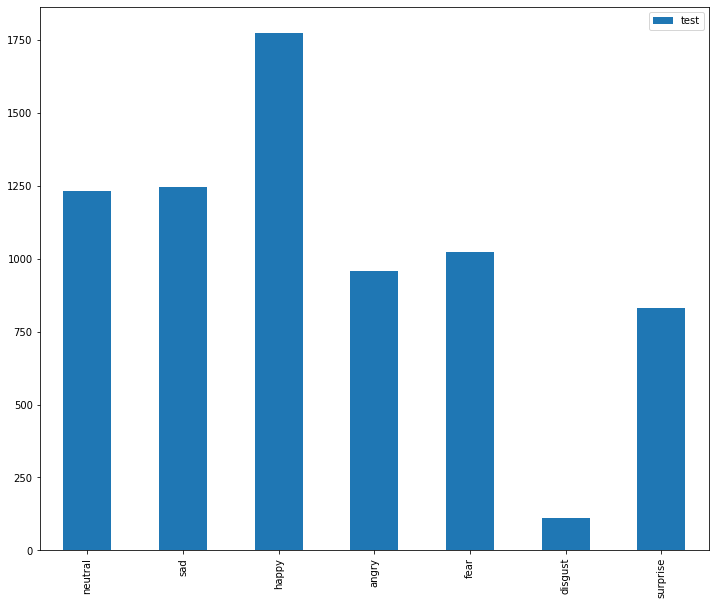

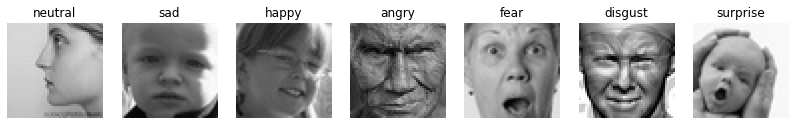

In [23]:
test_count.transpose().plot(kind='bar',figsize=(12, 10))

plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=fea492ea-45b1-45bc-9b38-4a1d1d39ebc1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>

# Data Preprocessing

